## Input and Output Files with Code Interpreter
CsvVisualizer demonstrates the creation and execution of an assistant using that receives a file of data as input and uses code interpreter to produce a chart image as output

## First steps
- First, download AntRunLib from Nuget
- At least once, set up the environment using **[0-AI-settings](0-AI-settings.ipynb)**

In [1]:
#r "nuget: AntRunnerLib, 0.8.8"

using AntRunnerLib;
using AntRunnerLib.Identity;
using static AntRunnerLib.ClientUtility;
using System.IO;

#!import config/Settings.cs 

var envVariables = Settings.GetEnvironmentVariables();
foreach (var kvp in envVariables)
{
    Environment.SetEnvironmentVariable(kvp.Key, kvp.Value);
}

var config = AzureOpenAiConfigFactory.Get();
var client = GetOpenAiClient(config);


Installed Packages AntRunnerLib, 0.8.8

## Ensure the CsvVisualizer assistant exists
The definition of this assistant is located in the ".\AssistantDefinitions\CsvVisualizer" folder

".\AssistantDefinitions\" is a default path. You can override it by setting the **ASSISTANTS_BASE_FOLDER_PATH** environment variable.

"CsvVisualizer" contains the following files:
```
│   manifest.json - The assistant definition
│   center0_height0.5_scale1.csv - A test file used in this notebook attached to the message
```

### Explanation
`AssistantUtility.Create` will create the assistant.

In [2]:
var assistantId = await AssistantUtility.Create("CsvVisualizer", config);
Console.WriteLine(assistantId)

asst_BhnQnw5tCOoaah3OV4LoBjCy


## Run the Assistant

`output.Dialog` shows the conversation.

In [3]:
var assistantRunOptions = new AssistantRunOptions() {
    AssistantName = "CsvVisualizer",
    Instructions = "Create a chart of the data in this file for me to download.",
};

assistantRunOptions.Files = new();
var resourceFile = new ResourceFile(){
    Path = @".\AssistantDefinitions\CsvVisualizer\center0_height0.5_scale1.csv",
    ResourceType = ResourceType.CodeInterpreterToolResource
};
assistantRunOptions.Files.Add(resourceFile);

var output = await AntRunnerLib.AssistantRunner.RunThread(assistantRunOptions, config);
output.Dialog.DisplayAs("text/markdown");


User: Create a chart of the data in this file for me to download.

Assistant: Let's first examine the contents of the uploaded file to understand what kind of data it contains. Then, we'll proceed to create a chart based on that data.

I'll start by loading and displaying the contents of the file.

I ran this code:
```
import pandas as pd

# Load the uploaded file
file_path = '/mnt/data/assistant-NkHHptQXMGM1WrgU7crhUFtp'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()
```

The dataset contains two columns: "Item" and "Frequency." 

Let's create a chart based on this data. I'll create a bar chart to visualize the frequency of each item.

I ran this code:
```
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(data['Item'], data['Frequency'], color='blue')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.title('Frequency of Items')
plt.xticks(rotation=90)
plt.tight_layout()

# Save the chart to a file
chart_path = '/mnt/data/item_frequency_chart.png'
plt.savefig(chart_path)

# Display the path to the saved chart
chart_path
```

I have created a bar chart based on the data and saved it as an image file. You can download the chart from the following link:

[Download the chart](sandbox:/mnt/data/item_frequency_chart.png)


In [4]:
output.LastMessage.DisplayAs("text/markdown");
string filePath = "";
// Download files specified in FilePathAnnotation
foreach (var annotation in output.Annotations)
{
    if (annotation.Type == "file_path")
    {
        var fileName = await annotation.GetFileName(config);

        filePath = Path.Combine(@".\", fileName);
        await annotation.DownloadFile(filePath, config);
        break;
    }
}

I have created a bar chart based on the data and saved it as an image file. You can download the chart from the following link:

[Download the chart](sandbox:/mnt/data/item_frequency_chart.png)

.\item_frequency_chart.png



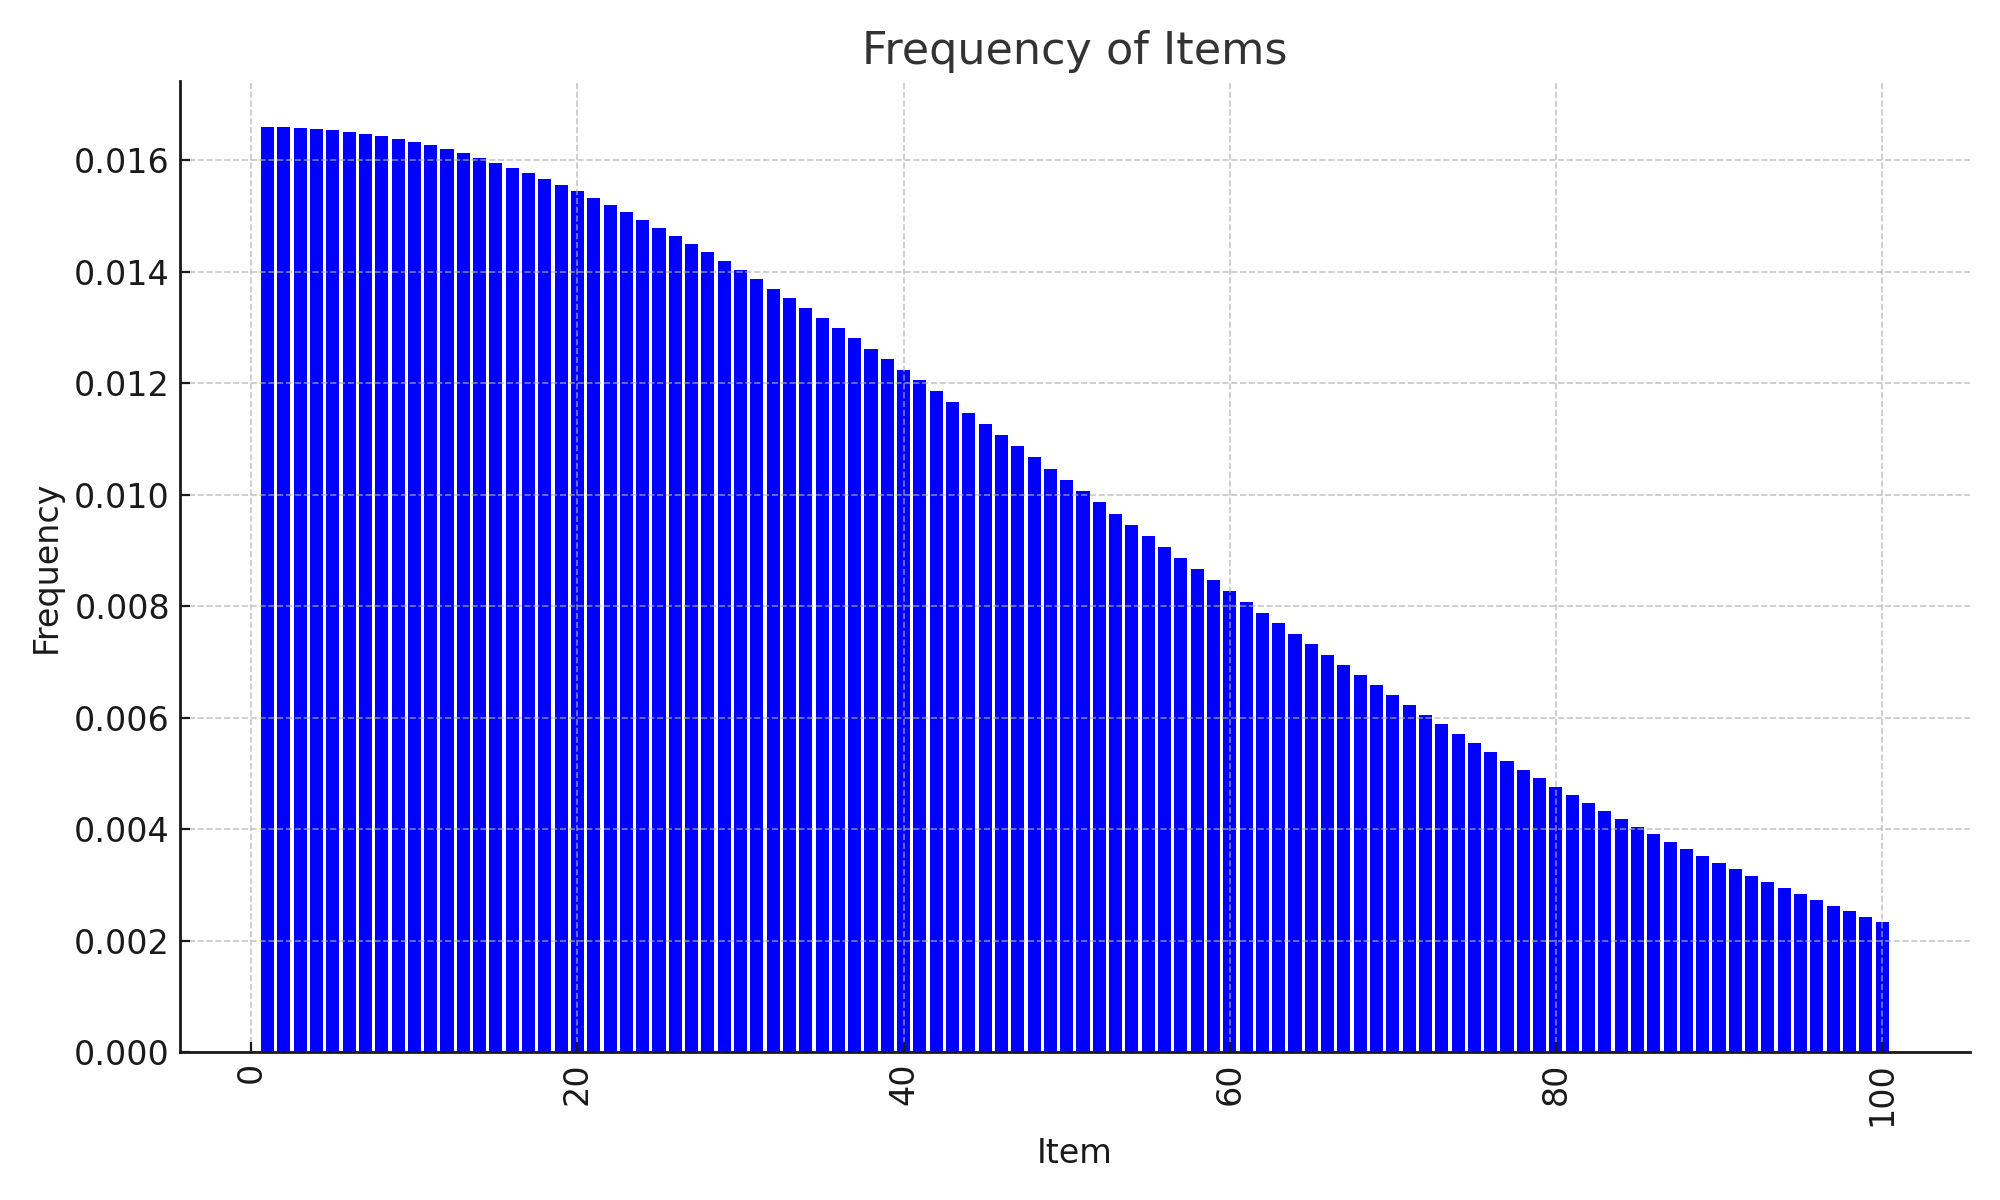

In [5]:
using System.IO;
using Microsoft.DotNet.Interactive.Formatting;
using static Microsoft.DotNet.Interactive.Formatting.PocketViewTags;

Console.WriteLine(filePath);
var imageBytes = File.ReadAllBytes(filePath);

// Convert the image to a base64 string
var base64Image = Convert.ToBase64String(imageBytes);

var htmlImage = img[src: $"data:image/png;base64,{base64Image}", alt: "Image"]();

// Use the display function to render the HTML
display(htmlImage);

## Annotations

In [6]:
Console.WriteLine(JsonSerializer.Serialize(output.Annotations, new JsonSerializerOptions() { WriteIndented = true }));

[
  {
    "type": "file_path",
    "text": "sandbox:/mnt/data/item_frequency_chart.png",
    "start_index": 150,
    "end_index": 192,
    "file_citation": null,
    "file_path": {
      "file_id": "assistant-EBGtizXNEN67bWJ9fihHkdyx"
    }
  }
]


## Clean Up

In [7]:
await client.DeleteFile(output.Annotations[0].FilePathAnnotation.FileId);

var assistant = (await client.AssistantList())?.Data?.FirstOrDefault(o => o.Name == "CsvVisualizer");

if(assistant != null) {
    await client.AssistantDelete(assistant.Id);
    Console.WriteLine("Deleted assistant");
}
else
{
    Console.WriteLine("Didn't find MsGraphUserProfile");
}

Deleted assistant
